# Machine Learning Final Project (CSCI 4050U)
---
###Members
*   Terry Darmawan Hosea (100670290)
*   Manmeet Choudhary (100459934)
*   Connor Robertson (100655338)





# **Import Libraries**

In [44]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import PIL
import io
import html
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.datasets as datasets

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as patches

pca = PCA(n_components=3)
haar_data = cv2.CascadeClassifier(cv2.data.haarcascades + './haarcascade_frontalface_default.xml')

# **Helper javascript functions for accessing webcam (video stream)**

*   js_to_image: Function that allows converting javascript object containing image via webcam to OpenCV Image 
*   bbox_to_bytes: Function that allows the generated facial bounding box image to base64 byte string to be overlayed in the webcam video stream
*   video_stream: JavaScript to properly create our live video stream using our webcam as input



>Reference: https://github.com/theAIGuysCode/colab-webcam/blob/main/colab_webcam.ipynb



In [45]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# JavaScript to properly create our live video stream using our webcam as input
def video_stream(shutdown=False):
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = shutdown;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# **Data collection by snapping several images**

In [ ]:
def collect_data(test_size, output_file):
  video_stream()
  label_html = 'Collecting Data'
  bbox = ''
  count = 0 
  test_size = test_size
  data = []
  print('Capturing ' + str(test_size) + ' Data: ', end='')
  capture = True

  #run webcam
  while capture:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      img = js_to_image(js_reply["img"])

      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      #detect faces from input image with haar cascade
      faces = haar_data.detectMultiScale(img)

      #apply rectangle boxes on detected faces
      for (x,y,w,h) in faces:

        #draw rectangle boxe around faces
        bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

        #convert image to grayscale
        face = cv2.cvtColor(cv2.resize(img[y:y+h, x:x+w, :], (100,100)),cv2.COLOR_RGB2GRAY)


        if(len(data) < test_size):
          if (len(data)+1) % 10 == 0:

            print(len(data)+1, end = ', ') 

          #add cropped face to dataset
          data.append(face)

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      bbox_bytes = bbox_to_bytes(bbox_array)
      bbox = bbox_bytes

      #export dataset
      if(len(data) == test_size):
        np.save(output_file, data)
        print('\n Data collection complete: ' + output_file, end = '\n')
        print(output_file + '[0]:')
        cv2_imshow(data[0])
        capture = False
  video_stream(True)

Collect data then save to .npy file format to increase read and write speed.



> Reference: https://towardsdatascience.com/what-is-npy-files-and-why-you-should-use-them-603373c78883



In [46]:
#Set constants

NO_MASK = 200
WITH_MASK = 200
IMPROPER_MASK = 200

NO_MASK_FILE = 'without_mask.npy'
WITH_MASK_FILE = 'with_mask.npy'
IMPROPER_MASK_FILE = 'improper_mask.npy'

<IPython.core.display.Javascript object>

Capturing 200 Data: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 
 Data collection complete: without_mask.npy
without_mask.npy[0]:


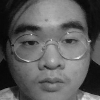

<IPython.core.display.Javascript object>

In [ ]:
#Collect data for
collect_data(NO_MASK, NO_MASK_FILE)

<IPython.core.display.Javascript object>

Capturing 200 Data: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 
 Data collection complete: with_mask.npy
with_mask.npy[0]:


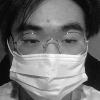

<IPython.core.display.Javascript object>

In [ ]:
#Collect data for with mask
collect_data(WITH_MASK, WITH_MASK_FILE)

<IPython.core.display.Javascript object>

Capturing 200 Data: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 
 Data collection complete: improper_mask.npy
improper_mask.npy[0]:


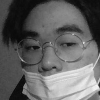

<IPython.core.display.Javascript object>

In [ ]:
#Collect data for improper mask
collect_data(IMPROPER_MASK, IMPROPER_MASK_FILE)

# **Importing and the dataset**

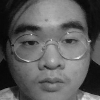

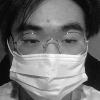

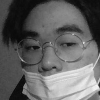

(200, 100, 100)
(200, 100, 100)
(200, 100, 100)


In [47]:
#Import the datasets
without_mask = np.load(NO_MASK_FILE)
with_mask = np.load(WITH_MASK_FILE)
improper_mask = np.load(IMPROPER_MASK_FILE)

#Showing data
without_mask_testdata = without_mask[0]
cv2_imshow(without_mask_testdata)

with_mask_testdata = with_mask[0]
cv2_imshow(with_mask_testdata)

improper_mask_testdata = improper_mask[0]
cv2_imshow(improper_mask_testdata)


#Dataset shape
print(with_mask.shape)
print(without_mask.shape)
print(improper_mask.shape)

# **Pre-processing data**

In [48]:
#Reducing the image dimension
with_mask = with_mask.reshape(WITH_MASK, np.prod(with_mask.shape[1:]))
without_mask = without_mask.reshape(NO_MASK, np.prod(without_mask.shape[1:]))
improper_mask = improper_mask.reshape(IMPROPER_MASK, np.prod(improper_mask.shape[1:]))

#Combine into single dataset for training
mask_data = np.concatenate([without_mask, with_mask, improper_mask])

mask_data.shape

(600, 10000)

# Generating training label

In [49]:
without_mask_label = np.full(without_mask.shape[0], 0)
with_mask_label = np.full(with_mask.shape[0], 1)
improper_mask_label = np.full(improper_mask.shape[0], 2)

labels = np.concatenate([without_mask_label, with_mask_label, improper_mask_label])
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# **Applying Machine Learning Techniques**

In [50]:
#Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(mask_data, labels, test_size=0.25)



print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (450, 10000)
y_train shape:  (450,)
x_test shape:  (150, 10000)
y_test shape:  (150,)


In [51]:
x_train = pca.fit_transform(x_train)
x_train.shape

(450, 3)

# **Model training with support vector machine (SVM) algorithm**

In [52]:
#Apply machine learning
svm = SVC()
svm.fit(x_train, y_train)

SVC()

In [53]:
#Get training accuracy
x_test = pca.transform(x_test)
y_pred = svm.predict(x_test)
accuracy_score(y_test, y_pred)

0.9666666666666667

# **Model can sometimes be overfitted, one way to know is if the training accuracy is 100%. To prevent this, we can keep looping until model training accuracy is within our desired accuracy**

In [54]:
#Generating and training a new model
def train_model(data, label, test_size, random_state):
  x_train, x_test, y_train, y_test = train_test_split(mask_data, labels, test_size=0.2, random_state=random_state)
  x_train = pca.fit_transform(x_train)

  svm = SVC()
  svm.fit(x_train, y_train)

  x_test = pca.transform(x_test)
  y_pred = svm.predict(x_test)
  
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy,svm



In [55]:
model_accuracy = None
model = None
MINIMAL_ACCURACY, MAXIMAL_ACCURACY = 0.95, 0.98
counter = 1

#We want a model that has a accuracy between MINIMAL_ACCURACY and MAXIMAL_ACCURACY with training data, to prevent overfitting
while ((model_accuracy is None or model_accuracy < MINIMAL_ACCURACY or model_accuracy > MAXIMAL_ACCURACY) and counter <= 50):
  model_accuracy, model = train_model(mask_data, labels, test_size=0.25, random_state=42)
  print(counter, model_accuracy)
  counter+=1

1 0.9833333333333333
2 0.9833333333333333
3 0.9833333333333333
4 0.9833333333333333
5 0.9833333333333333
6 0.9833333333333333
7 0.9833333333333333
8 0.9833333333333333
9 0.9833333333333333
10 0.9833333333333333
11 0.9833333333333333
12 0.9833333333333333
13 0.9833333333333333
14 0.9833333333333333
15 0.9833333333333333
16 0.9833333333333333
17 0.9833333333333333
18 0.9833333333333333
19 0.9833333333333333
20 0.9833333333333333
21 0.9833333333333333
22 0.9833333333333333
23 0.9833333333333333
24 0.9833333333333333
25 0.9833333333333333
26 0.9833333333333333
27 0.9833333333333333
28 0.9833333333333333
29 0.9833333333333333
30 0.9833333333333333
31 0.9833333333333333
32 0.9833333333333333
33 0.9833333333333333
34 0.9833333333333333
35 0.9833333333333333
36 0.9833333333333333
37 0.9833333333333333
38 0.9833333333333333
39 0.9833333333333333
40 0.9833333333333333
41 0.9833333333333333
42 0.9833333333333333
43 0.9833333333333333
44 0.9833333333333333
45 0.9833333333333333
46 0.98333333333333

# **Applying our model to live video**

In [56]:
def live_model_test(model, label):
  video_stream()
  label_html = 'Capturing...'
  bbox = ''
  
  count = 0 
  data = []
  c=(100,100,100)
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      img = js_to_image(js_reply["img"])

      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      faces = haar_data.detectMultiScale(gray)
      for (x,y,w,h) in faces:
        face  = cv2.cvtColor(cv2.resize(img[y:y+h, x:x+w, :], (100,100)),cv2.COLOR_RGB2GRAY)
        face = face.reshape(1,-1)
        face = pca.transform(face)

        #Model prediction
        pred_result = model.predict(face)
        label_result = label[int(pred_result)]
        
        #Labelling based on model prediction
        if(label_result == "No mask"):
          c=(255,0,0)
        elif(label_result == "Improper mask"):
          c=(255,255,0)
        else:
          c=(0,255,0)

        #Draw rectangle box around face and prediction text
        cv2.rectangle(bbox_array,(x,y),(x+w,y+h),c,2)
        cv2.putText(bbox_array, label_result, (x,y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, c, 2)

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      bbox_bytes = bbox_to_bytes(bbox_array)
      bbox = bbox_bytes

In [ ]:
label = {0: "No mask", 2: "Improper mask", 1: "Mask on"}
live_model_test(svm, label)

# CNN Model

In [ ]:
without_mask = np.load('./without_mask.npy')
with_mask = np.load('./with_mask.npy')
improper_mask = np.load('./improper_mask.npy')

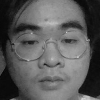

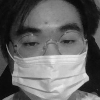

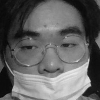

In [ ]:
without_mask_testdata = without_mask[-1]
cv2_imshow(without_mask_testdata)

with_mask_testdata = with_mask[-1]
cv2_imshow(with_mask_testdata)

improper_mask_testdata = improper_mask[-1]
cv2_imshow(improper_mask_testdata)

In [ ]:
#Combine datasets
mask_data = np.concatenate([without_mask, with_mask, improper_mask])

In [ ]:
#Generating training labels
without_mask_label = np.full(without_mask.shape[0], 0)
with_mask_label = np.full(with_mask.shape[0], 1)
improper_mask_label = np.full(improper_mask.shape[0], 2)


labels = np.concatenate([without_mask_label, with_mask_label, improper_mask_label])

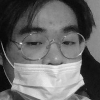

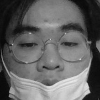

In [ ]:
#Splitting train and test data
x_train, x_test, y_train, y_test = train_test_split(mask_data, labels, test_size=0.25)

cv2_imshow(x_train[1])

cv2_imshow(x_train[-12])

In [ ]:
#Modelling
CNN_model = models.Sequential([
    layers.Input(shape=(100,100)),  #Input image size 100x100
    layers.Reshape((100,100,1)),
    layers.Conv2D(16, (5,5), padding='same'),  
    layers.MaxPooling2D((2,2)),                  
    layers.Conv2D(8, (5,5), padding='same'),
    layers.MaxPooling2D((2,2)),               
    layers.Flatten(),
    layers.Dense(3, activation='softmax'),  #3 categories result
])

CNN_model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=['sparse_categorical_accuracy'],
)


In [ ]:
#CNN model training

CNN_model.fit(x_train, y_train, epochs=10, verbose=2)

Epoch 1/10
15/15 - 11s - loss: 64.3190 - sparse_categorical_accuracy: 0.4289 - 11s/epoch - 717ms/step
Epoch 2/10
15/15 - 0s - loss: 6.0139 - sparse_categorical_accuracy: 0.7800 - 130ms/epoch - 9ms/step
Epoch 3/10
15/15 - 0s - loss: 0.5972 - sparse_categorical_accuracy: 0.9511 - 126ms/epoch - 8ms/step
Epoch 4/10
15/15 - 0s - loss: 0.3579 - sparse_categorical_accuracy: 0.9778 - 123ms/epoch - 8ms/step
Epoch 5/10
15/15 - 0s - loss: 0.1838 - sparse_categorical_accuracy: 0.9822 - 117ms/epoch - 8ms/step
Epoch 6/10
15/15 - 0s - loss: 0.1683 - sparse_categorical_accuracy: 0.9800 - 115ms/epoch - 8ms/step
Epoch 7/10
15/15 - 0s - loss: 0.0854 - sparse_categorical_accuracy: 0.9889 - 116ms/epoch - 8ms/step
Epoch 8/10
15/15 - 0s - loss: 0.0468 - sparse_categorical_accuracy: 0.9867 - 122ms/epoch - 8ms/step
Epoch 9/10
15/15 - 0s - loss: 0.1398 - sparse_categorical_accuracy: 0.9800 - 124ms/epoch - 8ms/step
Epoch 10/10
15/15 - 0s - loss: 0.1013 - sparse_categorical_accuracy: 0.9889 - 117ms/epoch - 8ms/st

In [ ]:
#Get model result
result = CNN_model.predict(x_test)
print(result)
result = np.argmax(result, axis=1)
result

[[1.00000000e+00 1.79252559e-08 1.31362577e-11]
 [1.88683417e-28 6.90015208e-04 9.99310017e-01]
 [2.10445818e-35 1.00000000e+00 7.38274701e-22]
 [3.84114200e-34 1.00000000e+00 8.37578074e-28]
 [8.33646918e-05 2.29972747e-12 9.99916673e-01]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [9.99990940e-01 9.05776324e-06 1.37025685e-13]
 [1.14273278e-23 1.00000000e+00 4.59117534e-29]
 [1.00000000e+00 1.01787480e-12 7.79725676e-15]
 [1.54403346e-31 1.00000000e+00 2.04520251e-36]
 [9.28207691e-36 1.60454285e-16 1.00000000e+00]
 [2.91616099e-35 4.65192995e-09 1.00000000e+00]
 [7.61057872e-26 1.00000000e+00 9.46650244e-25]
 [0.00000000e+00 1.09264845e-14 1.00000000e+00]
 [0.00000000e+00 1.06408034e-30 1.00000000e+00]
 [9.17908270e-21 5.98709886e-17 1.00000000e+00]
 [1.46609477e-31 5.12031410e-32 1.00000000e+00]
 [7.98037119e-29 1.00000000e+00 5.12084330e-09]
 [1.00000000e+00 1.68155245e-09 5.33324253e-12]
 [1.00000000e+00 7.61697261e-10 3.83006106e-14]
 [1.17181685e-20 1.00000000e+00 1.506616

array([0, 2, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 1, 0,
       2, 0, 2, 1, 2, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 2, 2, 1, 1, 0, 1,
       2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2,
       1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 0, 1, 0, 1, 2, 0, 0, 2, 1,
       2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 2,
       2, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1,
       1, 0, 0, 2, 2, 0, 1, 2, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

In [ ]:
def cnn_live_model_test(model, label):
  # start streaming video from webcam
  video_stream()
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 
  data = []
  c=(100,100,100)
  while True:
      js_reply = video_frame(label_html, bbox)
      if not js_reply:
          break

      img = js_to_image(js_reply["img"])

      bbox_array = np.zeros([480,640,4], dtype=np.uint8)

      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

      faces = haar_data.detectMultiScale(gray)
      for (x,y,w,h) in faces:

        face  = cv2.cvtColor(cv2.resize(img[y:y+h, x:x+w, :], (100,100)),cv2.COLOR_RGB2GRAY)
        face = face.reshape((1,100,100))

        pred_result = model.predict(face)
        label_result = label[np.argmax(pred_result)]

        c=(0,255,0)
        if(label_result == "No mask"):
          c=(255,0,0)

        elif(label_result == "Improper Mask"):
          c=(255, 255, 0)

        cv2.rectangle(bbox_array,(x,y),(x+w,y+h),c,2)
        cv2.putText(bbox_array, label_result, (x,y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, c, 2)

      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

  # np.save(output_file, data)

In [ ]:
label = {0: "No mask", 1: "Mask on", 2: "Improper Mask"}
cnn_live_model_test(CNN_model, label)